<a href="https://colab.research.google.com/github/pjcroxas/Remote-Sensing/blob/main/05_02_Data_Cleaning_of_Remote_Sensing_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Lesson 3. Clean Remote Sensing Data in Python - Clouds, Shadows & Cloud Masks

**About Landsat Scenes**
Landsat satellites orbit the earth continuously collecting images of the Earth’s surface. These images, are divided into smaller regions - known as scenes.





> Landsat images are usually divided into scenes for easy downloading. Each Landsat scene is about 115 miles long and 115 miles wide (or 100 nautical miles long and 100 nautical miles wide, or 185 kilometers long and 185 kilometers wide).


**Challenges Working with Landsat Remote Sensing Data**

In the previous lessons, you learned how to import a set of geotiffs that made up the bands of a Landsat raster. Each geotiff file was a part of a Landsat scene, that had been downloaded for this class by your instructor. The scene was further cropped to reduce the file size for the class.

You ran into some challenges when you began to work with the data. The biggest problem was a large cloud and associated shadow that covered your study area of interest - the Cold Springs fire burn scar.


**Work with Clouds, Shadows and Bad Pixels in Remote Sensing Data**

Clouds and atmospheric conditions present a significant challenge when working with multispectral remote sensing data. Extreme cloud cover and shadows can make the data in those areas, un-usable given reflectance values are either washed out (too bright - as the clouds scatter all light back to the sensor) or are too dark (shadows which represent blocked or absorbed light).

In this lesson you will learn how to deal with clouds in your remote sensing data. There is no perfect solution of course. You will just learn one approach.





In [ ]:
!pip install earthpy
!pip install rioxarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=ccd7c47f234d10e26c16216544ae6498eaebbe8d411f36c7dd65677b2411c0a1
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray


In [ ]:
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import ma
import xarray as xr
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em
import rioxarray as rxr

sns.set_style('white')
sns.set(font_scale=1.5)


data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

**Functions To Process Landsat Data**
<hr>

To begin, you can use the functions created in the previous lesson to process your Landsat data.

In [ ]:
def open_clean_band(band_path, crop_layer=None):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    crop_layer : geopandas geodataframe
        A geodataframe containing the clip extent of interest. NOTE: this will
        fail if the clip extent is in a different CRS than the raster data.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """

    if crop_layer is not None:
        try:
            clip_bound = crop_layer.geometry
            cleaned_band = rxr.open_rasterio(band_path,
                                             masked=True).rio.clip(clip_bound,
                                                                   from_disk=True).squeeze()
        except Exception as err:
            print("Oops, I need a geodataframe object for this to work.")
            print(err)
    else:
        cleaned_band = rxr.open_rasterio(band_path,
                                         masked=True).squeeze()

    return cleaned_band


def process_bands(paths, crop_layer=None, stack=False):
    """
    Open, clean and crop a list of raster files using rioxarray.

    Parameters
    ----------
    paths : list
        A list of paths to raster files that could be stacked (of the same
        resolution, crs and spatial extent).

    crop_layer : geodataframe
        A geodataframe containing the crop geometry that you wish to crop your
        data to.

    stack : boolean
        If True, return a stacked xarray object. If false will return a list
        of xarray objects.

    Returns
    -------
        Either a list of xarray objects or a stacked xarray object
    """

    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        cleaned["band"] = i+1
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        return xr.concat(all_bands, dim="band")
    else:
        print("Returning a list of xarray objects.")
        return all_bands

Next, you will load and plot landsat data. If you are completing the earth analytics course, you have worked with these data already in your homework.

HINT: Since we are only using the RGB and the NIR bands for this exercise, you can use `*band[2-5]*.tif` inside glob to filter just the needed bands. This will save a lot of time in processing since you will only be using the data you need.

Note that one thing was added to the functions below - a conditional that allows you to chose to either crop or not crop your data.

In [ ]:
landsat_dirpath_pre = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "*band[2-5]*.tif")

landsat_paths_pre = sorted(glob(landsat_dirpath_pre))
landsat_pre = process_bands(landsat_paths_pre, stack=True)
landsat_pre

I'm stacking your data now.


<xarray.DataArray (band: 4, y: 177, x: 246)>
array([[[ 443.,  456.,  446., ...,  213.,  251.,  293.],
        [ 408.,  420.,  436., ...,  226.,  272.,  332.],
        [ 356.,  375.,  373., ...,  261.,  329.,  383.],
        ...,
        [ 407.,  427.,  428., ...,  306.,  273.,  216.],
        [ 545.,  552.,  580., ...,  307.,  315.,  252.],
        [ 350.,  221.,  233., ...,  320.,  348.,  315.]],

       [[ 635.,  641.,  629., ...,  360.,  397.,  454.],
        [ 601.,  617.,  620., ...,  380.,  418.,  509.],
        [ 587.,  600.,  573., ...,  431.,  513.,  603.],
        ...,
        [ 679.,  742.,  729., ...,  493.,  482.,  459.],
        [ 816.,  827.,  824., ...,  461.,  502.,  485.],
        [ 526.,  388.,  364., ...,  463.,  501.,  512.]],

       [[ 625.,  671.,  651., ...,  265.,  307.,  340.],
        [ 568.,  620.,  627., ...,  309.,  354.,  431.],
        [ 513.,  510.,  515., ...,  362.,  464.,  565.],
        ...,
        [ 725.,  834.,  864., ...,  485.,  467.,  457.],
        [1031.,  864.,  844., ...,  438.,  457.,  429.],
        [ 525.,  432.,  411., ...,  465.,  472.,  451.]],

       [[2080., 1942., 1950., ..., 1748., 1802., 2135.],
        [2300., 2045., 1939., ..., 1716., 1783., 2131.],
        [2582., 2443., 2347., ..., 1836., 2002., 2241.],
        ...,
        [2076., 1993., 2145., ..., 1914., 2066., 2166.],
        [1910., 1899., 1962., ..., 1787., 2038., 2300.],
        [1633., 1611., 1738., ..., 1714., 1848., 2194.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 4.557e+05 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:  8481
    STATISTICS_MEAN:     664.90340361031
    STATISTICS_MINIMUM:  -767
    STATISTICS_STDDEV:   1197.873301452
    scale_factor:        1.0
    add_offset:          0.0

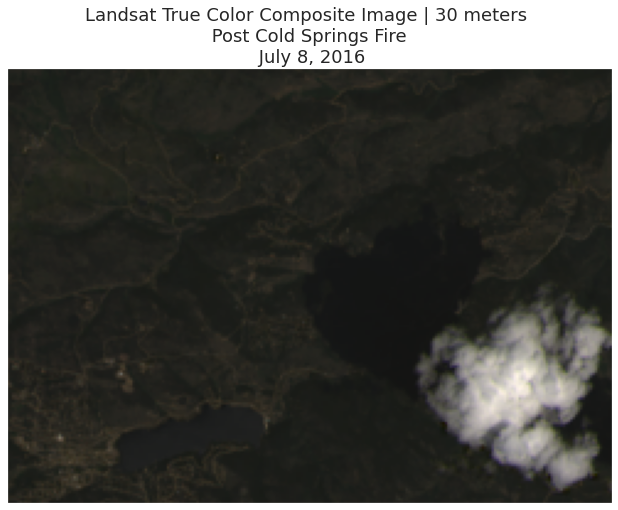

In [ ]:
# Plot the data
f, ax = plt.subplots(figsize=(15,8))
ep.plot_rgb(landsat_pre.values,
            rgb=[2,1,0],
            title="Landsat True Color Composite Image | 30 meters \n Post Cold Springs Fire \n July 8, 2016",
            ax=ax)

plt.show()

Notice in the data above there is a large cloud in your scene. This cloud will impact any quantitative analysis that you perform on the data. You can remove cloudy pixels using a mask. Masking “bad” pixels:

1. Allows you to remove them from any quantitative analysis that you may perform such as calculating NDVI.

2. Allows you to replace them (if you want) with better pixels from another scene. This replacement if often performed when performing time series analysis of data. The following lesson will teach you have to replace pixels in a scene.

**Cloud Masks in Python**
You can use the cloud mask layer to identify pixels that are likely to be clouds or shadows. You can then set those pixel values to `masked` so they are not included in your quantitative analysis in Python.

When you say “mask”, you are talking about a layer that “turns off” or sets to `nan`, the values of pixels in a raster that you don’t want to include in an analysis. It’s very similar to setting data points that equal -9999 to `nan` in a time series data set. You are just doing it with spatial raster data instead.

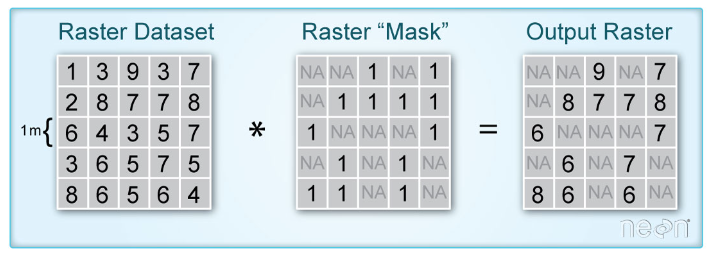

<small> When you use a raster mask, you are defining what pixels you want to exclude from a quantitative analysis. Notice in this image, the raster max is simply a layer that contains values of 1 (use these pixels) and values of NA (exclude these pixels). If the raster is the same extent and spatial resolution as your remote sensing data (in this case your landsat raster stack) you can then mask ALL PIXELS that occur at the spatial location of clouds and shadows (represented by an NA in the image above). Source: Colin Williams (NEON)

**Raster Masks for Remote Sensing Data**

Many remote sensing data sets come with quality layers that you can use as a mask to remove “bad” pixels from your analysis. In the case of Landsat, the mask layers identify pixels that are likely representative of cloud cover, shadow and even water. When you download Landsat 8 data from Earth Explorer, the data came with a processed cloud shadow / mask raster layer called landsat_file_name_pixel_qa.tif. Just replace the name of your Landsat scene with the text landsat_file_name above. For this class the layer is:

`LC80340322016189-SC20170128091153/crop/`

`LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif`

You will explore using this pixel quality assurance (QA) layer, next. To begin, open the pixel_qa layer using rioxarray and plot it with matplotlib.

In [ ]:
# Open the landsat QA Layer
landsat_pre_cl_path = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

landsat_qa = rxr.open_rasterio(landsat_pre_cl_path).squeeze()

high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence

# Mask the data using the pixel QA Layer
landsat_pre_cl_free = landsat_pre.where(~landsat_qa.isin(all_masked_values))

In [ ]:
landsat_pre_cl_free

<xarray.DataArray (band: 4, y: 177, x: 246)>
array([[[ 443.,  456.,  446., ...,  213.,  251.,  293.],
        [ 408.,  420.,  436., ...,  226.,  272.,  332.],
        [ 356.,  375.,  373., ...,  261.,  329.,  383.],
        ...,
        [ 407.,  427.,  428., ...,  306.,  273.,  216.],
        [ 545.,  552.,  580., ...,  307.,  315.,  252.],
        [ 350.,  221.,  233., ...,  320.,  348.,  315.]],

       [[ 635.,  641.,  629., ...,  360.,  397.,  454.],
        [ 601.,  617.,  620., ...,  380.,  418.,  509.],
        [ 587.,  600.,  573., ...,  431.,  513.,  603.],
        ...,
        [ 679.,  742.,  729., ...,  493.,  482.,  459.],
        [ 816.,  827.,  824., ...,  461.,  502.,  485.],
        [ 526.,  388.,  364., ...,  463.,  501.,  512.]],

       [[ 625.,  671.,  651., ...,  265.,  307.,  340.],
        [ 568.,  620.,  627., ...,  309.,  354.,  431.],
        [ 513.,  510.,  515., ...,  362.,  464.,  565.],
        ...,
        [ 725.,  834.,  864., ...,  485.,  467.,  457.],
        [1031.,  864.,  844., ...,  438.,  457.,  429.],
        [ 525.,  432.,  411., ...,  465.,  472.,  451.]],

       [[2080., 1942., 1950., ..., 1748., 1802., 2135.],
        [2300., 2045., 1939., ..., 1716., 1783., 2131.],
        [2582., 2443., 2347., ..., 1836., 2002., 2241.],
        ...,
        [2076., 1993., 2145., ..., 1914., 2066., 2166.],
        [1910., 1899., 1962., ..., 1787., 2038., 2300.],
        [1633., 1611., 1738., ..., 1714., 1848., 2194.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 4.557e+05 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:  8481
    STATISTICS_MEAN:     664.90340361031
    STATISTICS_MINIMUM:  -767
    STATISTICS_STDDEV:   1197.873301452
    scale_factor:        1.0
    add_offset:          0.0

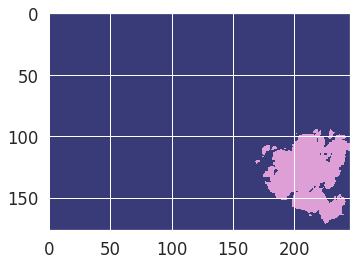

In [ ]:
plt.imshow(landsat_qa,
           cmap=plt.cm.get_cmap('tab20b', 2))

In the image above, you can see the cloud and the shadow that is obstructing our landsat image. Unfortunately for you, this cloud covers a part of your analysis area in the Cold Springs Fire location. There are a few ways to handle this issue. We will look at one: simply masking out or removing the cloud for your analysis, first.

To remove all pixels that are cloud and cloud shadow covered we need to first determine what each value in our qa raster represents. The table below is from the USGS landsat website. It describes what all of the values in the pixel_qa layer represent.

We are interested in

1. cloud shadow
2. cloud and
3. high confidence cloud


Note that your specific analysis may require a different set of masked pixels. For instance, your analysis may require you identify pixels that are low confidence clouds too. We are just using these classes for the purpose of this class.

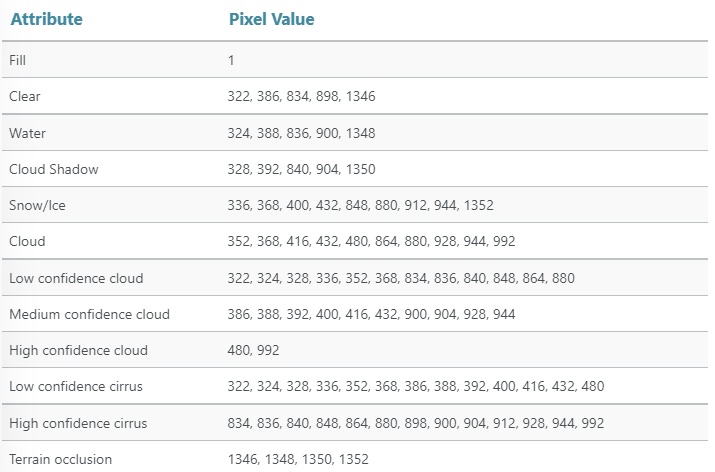

To better understand the values above, create a better map of the data. To do that you will:

1. classify the data into x classes where x represents the total number of unique values in the pixel_qa raster.
2. plot the data using these classes.

We are reclassifying the data because matplotlib colormaps will assign colors to values along a continuous gradient. Reclassifying the data allows us to enforce one color for each unique value in our data.

This next section shows you how to create a mask using the xarray function isin() to create a binary cloud mask layer. In this mask all pixels that you wish to remove from your analysis or mask will be set to 1. All other pixels which represent pixels you want to use in your analysis will be set to 0.

In [ ]:
# You can grab the cloud pixel values from earthpy
high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence
all_masked_values

[328,
 392,
 840,
 904,
 1350,
 352,
 368,
 416,
 432,
 480,
 864,
 880,
 928,
 944,
 992,
 480,
 992]

In [ ]:
# Create the cloud mask
cl_mask = landsat_qa.isin(all_masked_values)
np.unique(cl_mask)

array([False,  True])

In [ ]:
cl_mask

<xarray.DataArray (y: 177, x: 246)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    band         int64 1
  * x            (x) float64 4.557e+05 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int64 0

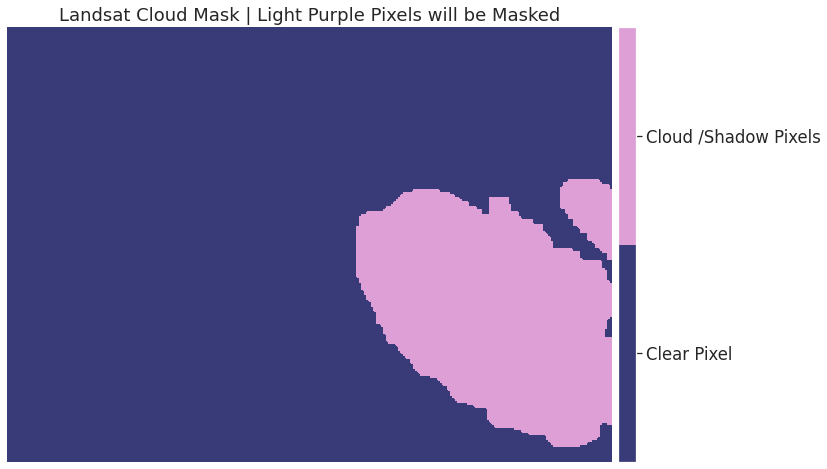

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(cl_mask,
               cmap=plt.cm.get_cmap('tab20b', 2))

cbar = ep.colorbar(im)
cbar.set_ticks((0.25, 0.75))
cbar.ax.set_yticklabels(["Clear Pixel", "Cloud /Shadow Pixels"])

ax.set_title("Landsat Cloud Mask | Light Purple Pixels will be Masked")
ax.set_axis_off()
plt.show()

**What Does the Metadata Tell You?**
<hr>

You just explored two layers that potentially have information about cloud cover. However what do the values stored in those rasters mean? You can refer to the metadata provided by USGS to learn more about how each layer in your landsat dataset are both stored and calculated.

When you download remote sensing data, often (but not always), you will find layers that tell us more about the error and uncertainty in the data. Often whomever created the data will do some of the work for us to detect where clouds and shadows are - given they are common challenges that you need to work around when using remote sensing data.

**Create Mask Layer in Python**

To create the mask this you do the following:

1. Make sure you use a raster layer for the mask that is the SAME EXTENT and the same pixel resolution as your landsat scene. In this case you have a mask layer that is already the same spatial resolution and extent as your landsat scene.
2. Set all of the values in that layer that are clouds and / or shadows to True
3. Finally you use the `where` function to apply the mask layer to the xarray DataArray (or the landsat scene that you are working with in Python). all pixel locations that were flagged as clouds or shadows in your mask to NA in your `raster` or in this case `rasterstack.`

**Mask A Landsat Scene Using Xarray**


Below you mask your data in one single step. This function .where() applies the mask you created above to your xarray DataArray. To apply the mask, ensure you put a ~ in front of your mask inside the where() function. This must be done because isin() creates the mask with True values where we want False, values, and vice versa. The ~ flips all of the values inside the array.

In [ ]:
# Mask your data using .where()
landsat_pre_cl_free = landsat_pre.where(~cl_mask)

In [ ]:
# Mask your data and create the mask using one single line of code
landsat_pre_cl_free = landsat_pre.where(~landsat_qa.isin(all_masked_values))

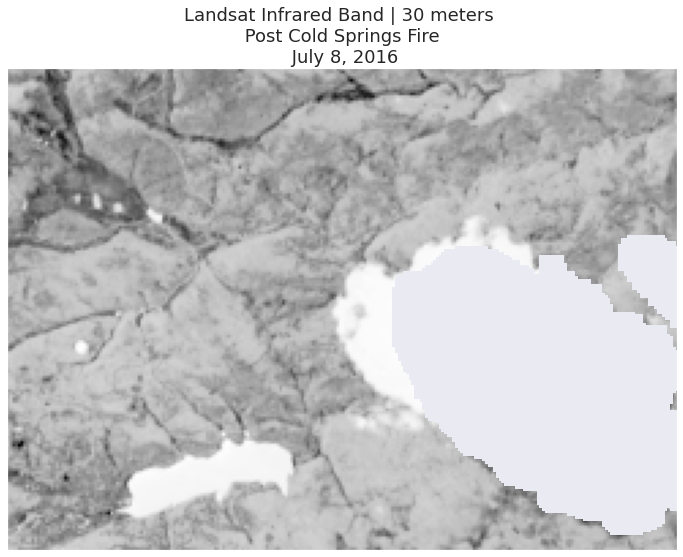

In [ ]:
# Plot the data
ep.plot_bands(landsat_pre_cl_free[3],
              cmap="Greys",
              title="Landsat Infrared Band | 30 meters \n Post Cold Springs Fire \n July 8, 2016",
              cbar=False)
plt.show()

<small> CIR Composite image in grey scale with mask applied, covering the post-Cold Springs fire area on July 8, 2016.

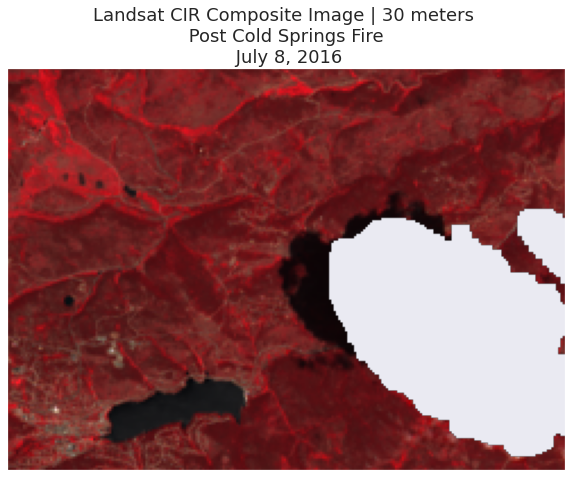

In [ ]:
ep.plot_rgb(landsat_pre_cl_free,
            rgb=[3,2,1],
            title="Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire \n July 8, 2016")

plt.show()